In [1]:
from exp.nb_Tesis import *


In [2]:
# pip install --upgrade efficientnet-pytorch


In [3]:
urls2019 = ['https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip',
        'https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv']

In [4]:
# for idx,url in enumerate(urls2019):
#   !wget $url

In [5]:
# !unzip ISIC_2019_Training_Input.zip

In [6]:
min_dim = 128# 448

trainImagesFolderName = 'ISIC_2019_Training_Input'
trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'
testImagesFolderName = 'ISIC2018_Task3_Test_Input'
smallTestImagesFolderName = f'small_{min_dim}_ISIC2018_Task3_Test_Input'

trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'


In [7]:
df = pd.read_csv(trainingGroundTruthFileName); print('# of images: ', len(df)); df.head()

# of images:  25331


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
dfSingleLabel = pd.DataFrame({'image':df['image'] })
labelcols = df.columns[1:len(df.columns)]
dfSingleLabel['label'] = df[list(labelcols)].idxmax(axis='columns')
dfSingleLabel.head()

,image,label
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


In [9]:
#export
labels_for_2018_live_challenge = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']

def get_label_for_image_name(image_name):
  return list(dfSingleLabel.loc[dfSingleLabel['image']==image_name].label)[0]
  
def get_label_for_image_path(image_path): return get_label_for_image_name(image_path.name[:-4])

#### Prune the dataset if needed

In [10]:
labels_exclusive_for_2019 = ['SCC']
training_for_2018 = True
max_of_each = 30
classDict = {}
images = get_image_files(trainImagesFolderName)
newFolder = f'picked_{max_of_each}_{trainImagesFolderName}'
destFolder = Path(newFolder)
destFolder.mkdir(parents=True, exist_ok=True);

def prune_dataset(image,idx):
    label = get_label_for_image_path(image)
    if training_for_2018 and label in labels_exclusive_for_2019: return
    if label in classDict: classDict[label] = classDict[label] + 1
    else: classDict[label] = 1
    if classDict[label] < max_of_each:
        !cp './'$image $destFolder'/'
#         print(classDict[label],max_of_each)

# parallel(partial(prune_dataset),images)
    

#### Remove warnings

In [11]:
!nvidia-smi

Sat Mar  7 18:15:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:01:00.0 Off |                  N/A |
| 33%   61C    P2   175W / 250W |   1211MiB / 11176MiB |     68%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [12]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [13]:
# torch.cuda.set_device(0)

## Load the dataset

In [14]:
destFolder

PosixPath('picked_30_ISIC_2019_Training_Input')

In [16]:
def reload_dataset(imgs_folder):
    random_seed(1,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.8, max_lighting=.3,p_affine=1, max_warp=0)

    data = ImageList.from_folder(imgs_folder)\
    .split_by_rand_pct()\
    .label_from_func(get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=16)\
    .normalize()
    return data

data = reload_dataset(destFolder)

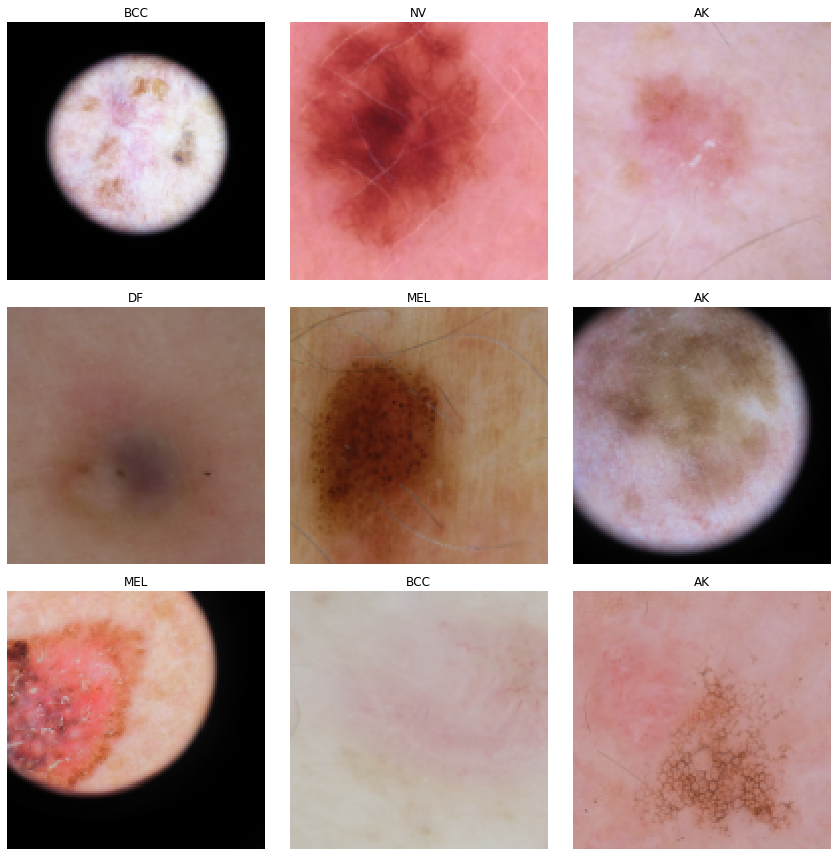

In [22]:
data.show_batch(3)

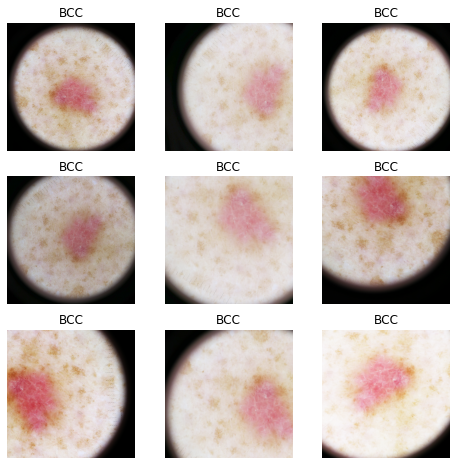

In [23]:
def _plot(i,j,ax):
    x,y = data.train_ds[1]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [24]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 AK      385
BCC     379
MEL     370
BKL     370
NV      365
DF      194
VASC    187
dtype: int64 

 valid_count: 
 NV      99
MEL     94
BKL     94
BCC     85
AK      79
VASC    66
DF      45
dtype: int64
ratios:
AK      0.205195
BCC     0.224274
BKL     0.254054
DF      0.231959
MEL     0.254054
NV      0.271233
VASC    0.352941
dtype: float64 %


In [19]:
#export

# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

def get_class_weights(data):
    train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
    train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

    weighted_classes = [{c: (sum(train_count) / train_count[c] * len(data.classes))} for c in data.classes];
    print(weighted_classes)
    formatted_weights = [w[c] for c,w in zip(data.classes, weighted_classes) ]
    class_weights=torch.FloatTensor(formatted_weights).cuda()
    class_weights = class_weights / sum(class_weights)
    return class_weights

def train_learner(learner, name, epochs=8, lr=1e-3, wd = 1e-4, balanced=True):
    if balanced: learner.loss_func = CrossEntropyFlat(weight = get_class_weights(learner.data))
    random_seed(1,True)
    log_name = f'2019_imgsz_{learner.data.valid_ds[0][0].shape[1]}_{name}'
    print("Saving log on: ",log_name)
    learner.fit_one_cycle(epochs,max_lr=lr,wd=wd, callbacks = [
        SaveModelCallback(learn=learner,name=log_name,monitor='accuracy'),
        CSVLogger(learn=learner,filename=log_name)
    #     ReduceLROnPlateauCallback(learn=learn)
    ])

# 1) Experiment: DenseNet201 vs EfficientNet-b0 vs EfficientNet-b3

First let's see the difference between efficientnet and densenet201 all things being equal
Variables:
* Images prerezised to: 128px

* get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.6, max_lighting=.3,p_affine=1, max_warp=0)
* batch_size = 16
* random_seed 1
* epochs = 8 
* one_cycle_policy, max_lr = 1e-3, wd 1e-4
* balancing per class: True
* pretrained = True
* unfreezed = True

train_count: 
 BKL     313
NV      311
AK      305
MEL     300
BCC     297
SCC     278
VASC    196
DF      192
dtype: int64 

 valid_count: 
 BCC     80
AK      80
MEL     78
SCC     70
BKL     69
NV      66
VASC    57
DF      47
dtype: int64

## Experiment body

In [26]:
images_folder = 'picked_30_ISIC_2019_Training_Input'
data = reload_dataset(images_folder)

### Efficientnet-b0

In [20]:
from efficientnet_pytorch import EfficientNet

random_seed(1,True)

model_name = 'efficientnet-b0'
model_b0 = EfficientNet.from_pretrained(model_name)
model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0 = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                ])

# learn_b0.summary()

Loaded pretrained weights for efficientnet-b0


In [28]:
0.469751

0.469751

[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.634818,1.436159,0.539146,0.460854,0.624293,00:16
1,1.376907,1.307250,0.517794,0.482206,0.526423,00:13
2,1.295629,1.389935,0.492883,0.507117,0.321302,00:14
3,1.174619,1.419769,0.523132,0.476868,0.515909,00:14
4,1.042902,1.058657,0.398576,0.601424,0.507106,00:14
5,0.935697,1.006752,0.402135,0.597865,0.405488,00:13
6,0.783146,0.900418,0.359431,0.640569,0.449606,00:23
7,0.733985,0.861521,0.346975,0.653025,0.401942,00:26


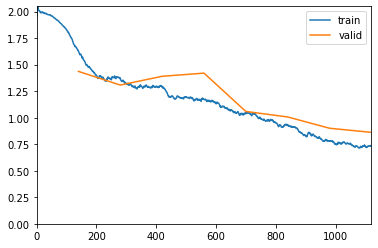

Better model found at epoch 0 with accuracy value: 0.46085408329963684.
Better model found at epoch 1 with accuracy value: 0.48220640420913696.
Better model found at epoch 2 with accuracy value: 0.5071174502372742.
Better model found at epoch 4 with accuracy value: 0.6014235019683838.
Better model found at epoch 6 with accuracy value: 0.6405693888664246.
Better model found at epoch 7 with accuracy value: 0.6530249118804932.


RuntimeError: Could not infer dtype of NoneType

In [21]:
train_learner(learn_b0,'EfficientNet-b0')

### Densenet

In [65]:
random_seed(1,True)

dense_learn = cnn_learner(data,models.densenet201, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ],
                         pretrained=True
                        )

dense_learn.unfreeze()

# dense_learn.summary()

[{'AK': 0.4857142857142857}, {'BCC': 0.49340369393139843}, {'BKL': 0.5054054054054054}, {'DF': 0.9639175257731959}, {'MEL': 0.5054054054054054}, {'NV': 0.5123287671232877}, {'VASC': 1.0}]
Saving log on:  2019_imgsz_128_DenseNet-201


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.308229,2.084784,0.560498,0.439502,0.463830,00:34
1,2.102988,2.700191,0.608541,0.391459,0.422247,00:34
2,1.926949,1.824177,0.622776,0.377224,0.378764,00:34
3,1.849470,2.054591,0.569395,0.430605,0.314885,00:34
4,1.875659,1.619285,0.594306,0.405694,0.362141,00:34
5,1.693434,1.586588,0.514235,0.485765,0.571267,00:34
6,1.578990,1.359651,0.467972,0.532028,0.531163,00:35
7,1.455144,1.183475,0.441281,0.558719,0.560981,00:34


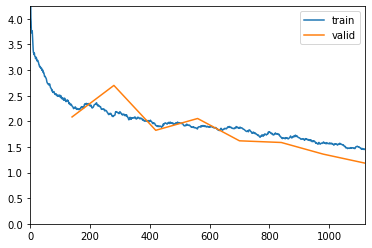

Better model found at epoch 0 with accuracy value: 0.4395017921924591.
Better model found at epoch 5 with accuracy value: 0.48576512932777405.
Better model found at epoch 6 with accuracy value: 0.5320284962654114.
Better model found at epoch 7 with accuracy value: 0.5587188601493835.


In [66]:
train_learner(dense_learn,'DenseNet-201')

### EfficientNet-b3

In [67]:
from efficientnet_pytorch import EfficientNet

random_seed(1,True)

model_name = 'efficientnet-b3'
model_b3 = EfficientNet.from_pretrained(model_name)
model_b3._fc = nn.Linear(1536, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b3 = Learner(data,model_b3, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

# learn_b3.summary()

Loaded pretrained weights for efficientnet-b3


[{'AK': 0.4857142857142857}, {'BCC': 0.49340369393139843}, {'BKL': 0.5054054054054054}, {'DF': 0.9639175257731959}, {'MEL': 0.5054054054054054}, {'NV': 0.5123287671232877}, {'VASC': 1.0}]
Saving log on:  2019_imgsz_128_EfficientNet-b3


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.624334,1.367198,0.530249,0.469751,0.500728,00:20
1,1.424780,2.186345,0.656584,0.343416,0.381921,00:20
2,1.340718,1.363781,0.475089,0.524911,0.259933,00:20
3,1.281468,1.281354,0.496441,0.503559,0.516389,00:20
4,1.138185,1.208177,0.439502,0.560498,0.451794,00:20
5,0.947680,0.976376,0.377224,0.622776,0.388359,00:20
6,0.833126,0.843020,0.339858,0.660142,0.429498,00:20
7,0.763343,0.812515,0.330961,0.669039,0.446393,00:20


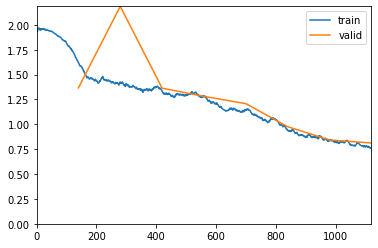

Better model found at epoch 0 with accuracy value: 0.46975088119506836.
Better model found at epoch 2 with accuracy value: 0.5249110460281372.
Better model found at epoch 4 with accuracy value: 0.5604982376098633.
Better model found at epoch 5 with accuracy value: 0.6227757930755615.
Better model found at epoch 6 with accuracy value: 0.6601423621177673.
Better model found at epoch 7 with accuracy value: 0.6690391302108765.


RuntimeError: Could not infer dtype of NoneType

In [68]:
train_learner(learn_b3,'EfficientNet-b3')

# Conclusion

* Accuracy: EfficientNet-b3 (0.669039) > EfficientNet-b0 (0.658363) > DenseNet-201 (0.558719)
* DenseNet no solo llega a la menor accuracy si no que entrena lento

In [73]:
print('densenet accuracy:', dense_learn.validate()[2].item())
print('b0 accuracy:', learn_b0.validate()[2].item())
print('b3 accuracy:', learn_b3.validate()[2].item())

densenet accuracy: 0.5587188601493835


b0 accuracy: 0.6583629846572876


b3 accuracy: 0.6690391302108765


# 2) Experiment: Balance or not class weights on EfficientNet-b0

* Images prerezised to: 128px

* get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.6, max_lighting=.3,p_affine=1, max_warp=0)
* batch_size = 16
* random_seed 1
* epochs = 8 
* one_cycle_policy, max_lr = 1e-3, wd 1e-4
* balancing per class: VARIABLE
* pretrained = True
* unfreezed = True

train_count: 
 MEL     886
BKL     879
BCC     879
NV      874
AK      695
DF      207
VASC    200
dtype: int64 



 valid_count: 
 NV      230
BKL     225
BCC     225
MEL     218
AK      172
VASC     53
DF       32
dtype: int64



ratios:
AK      0.247482
BCC     0.255973
BKL     0.255973
DF      0.154589
MEL     0.246050
NV      0.263158
VASC    0.265000
dtype: float64 %

## Experiment body

In [217]:
images_folder = 'picked_70_ISIC_2019_Training_Input'
data = reload_dataset(images_folder)

In [161]:
#export
def plot_conf_matrix(interpretation):
    interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)
    print("Balanced accuracy: ", get_balanced_accurracy(interpretation))
    plt.tight_layout()

def get_balanced_accurracy(interpretation):
    matrix = interpretation.confusion_matrix()
    balanced_acc = 0
    for i in range(len(matrix[0])):
        row = matrix[i]
        correctGuesses = row[i]
        allPossibleTries = row.sum()
        classAcurracy = correctGuesses / allPossibleTries
        balanced_acc += classAcurracy
    balanced_acc /= len(matrix[0])
    return balanced_acc



### Balanced Efficientnet-b0

##### train

In [162]:
from efficientnet_pytorch import EfficientNet

random_seed(1,True)

model_name = 'efficientnet-b0'
model_b0 = EfficientNet.from_pretrained(model_name)
model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0 = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

# learn_b0.summary()

Loaded pretrained weights for efficientnet-b0


In [163]:
get_class_weights(learn_b0.data)

[{'AK': 46.53237410071943}, {'BCC': 36.791808873720136}, {'BKL': 36.791808873720136}, {'DF': 156.231884057971}, {'MEL': 36.50112866817156}, {'NV': 37.002288329519445}, {'VASC': 161.70000000000002}]


tensor([0.0910, 0.0719, 0.0719, 0.3054, 0.0714, 0.0723, 0.3161],
       device='cuda:0')

In [164]:
0.526407

0.526407

[{'AK': 46.53237410071943}, {'BCC': 36.791808873720136}, {'BKL': 36.791808873720136}, {'DF': 156.231884057971}, {'MEL': 36.50112866817156}, {'NV': 37.002288329519445}, {'VASC': 161.70000000000002}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.413569,1.228570,0.473593,0.526407,0.597429,00:26
1,1.284906,1.298266,0.482251,0.517749,0.426786,00:26
2,1.218937,1.508092,0.512554,0.487446,0.459618,00:26
3,1.158830,1.039274,0.394805,0.605195,0.581290,00:26
4,1.049562,0.906426,0.380087,0.619913,0.507957,00:26
5,0.861304,0.812463,0.344589,0.655411,0.336612,00:26
6,0.807014,0.735523,0.315152,0.684848,0.396258,00:26
7,0.726023,0.726270,0.316883,0.683117,0.398155,00:26


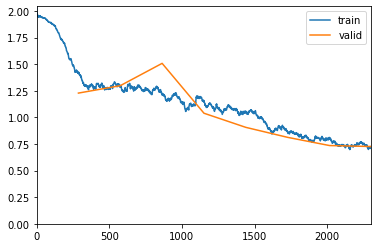

Better model found at epoch 0 with accuracy value: 0.5264069437980652.
Better model found at epoch 3 with accuracy value: 0.6051948070526123.
Better model found at epoch 4 with accuracy value: 0.6199133992195129.
Better model found at epoch 5 with accuracy value: 0.6554112434387207.
Better model found at epoch 6 with accuracy value: 0.6848484873771667.


RuntimeError: Could not infer dtype of NoneType

In [165]:
train_learner(learn_b0, 'EfficientNet-b0')

##### interp

In [166]:
interp = ClassificationInterpretation.from_learner(learn_b0)

Balanced accuracy:  0.7402384281095197


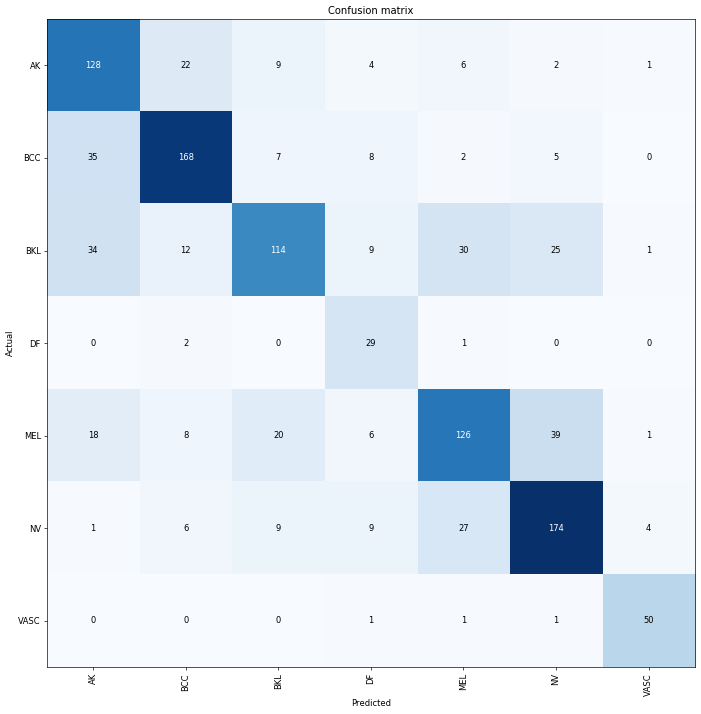

In [167]:
plot_conf_matrix(interp)
plt.tight_layout()

### Unbalanced efficientnet-b0

##### train

In [169]:
from efficientnet_pytorch import EfficientNet

random_seed(1,True)

model_name = 'efficientnet-b0'
model_b0_unb = EfficientNet.from_pretrained(model_name)
model_b0_unb._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0_unb = Learner(data,model_b0_unb, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

# learn_b0_unb.summary()

Loaded pretrained weights for efficientnet-b0


Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.378533,1.197431,0.471861,0.528139,0.513496,00:26
1,1.285354,1.233189,0.471861,0.528139,0.460033,00:27
2,1.272398,1.257911,0.478788,0.521212,0.416067,00:27
3,1.154173,1.072976,0.393939,0.606061,0.331622,00:26
4,1.031246,1.079400,0.396537,0.603463,0.464282,00:27
5,0.928947,0.838912,0.318615,0.681385,0.491976,00:27
6,0.830068,0.798499,0.308225,0.691775,0.505701,00:27
7,0.761560,0.785482,0.296104,0.703896,0.494026,00:27


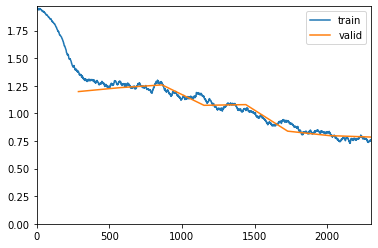

Better model found at epoch 0 with accuracy value: 0.5281385183334351.
Better model found at epoch 3 with accuracy value: 0.6060606241226196.
Better model found at epoch 5 with accuracy value: 0.6813852787017822.
Better model found at epoch 6 with accuracy value: 0.6917749047279358.
Better model found at epoch 7 with accuracy value: 0.7038961052894592.


RuntimeError: Could not infer dtype of NoneType

In [170]:
train_learner(learn_b0_unb, 'EfficientNet-b0', balanced=False)

##### interp

In [171]:
interp_unb = ClassificationInterpretation.from_learner(learn_b0_unb)

Balanced accuracy:  0.7403252633017725


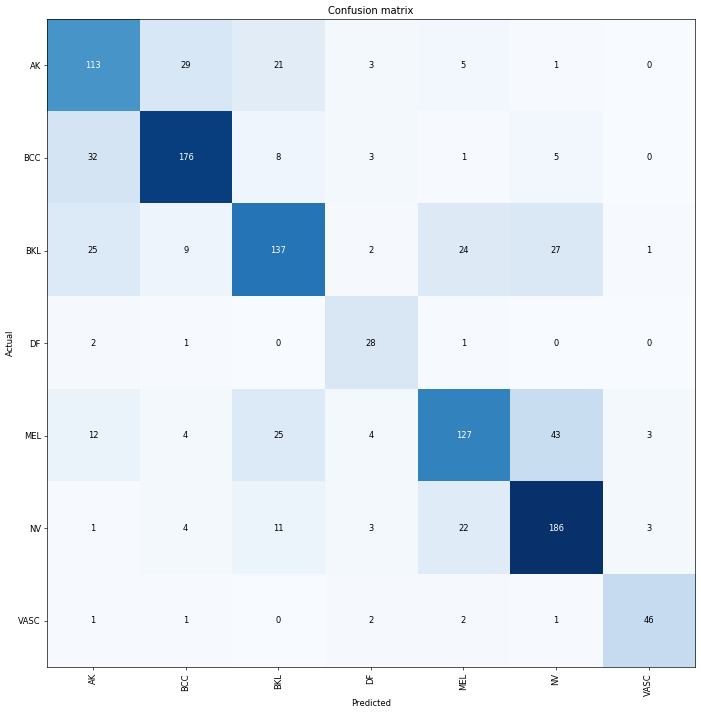

In [172]:
plot_conf_matrix(interp_unb)
plt.tight_layout()

# Conclusion

In [195]:
def get_class_acc(anInterpretation, aClass):
    idx_class = data.classes.index(aClass)
    class_row = anInterpretation.confusion_matrix()[idx_class]
    class_acc = class_row[idx_class] / sum(class_row)
    return class_acc

In [213]:
b_acc = get_balanced_accurracy(interp)
b_acc_unb = get_balanced_accurracy(interp_unb)

acc_index = 2

df = pd.DataFrame({'Sin pesar por clase':
                   [b_acc_unb,
                    learn_b0_unb.validate()[acc_index].item(),
                    get_class_acc(interp_unb,'VASC'),
                    get_class_acc(interp_unb,'DF')
                   ],
                   'Pesando por clase':
                   [b_acc, learn_b0.validate()[acc_index].item(),
                   get_class_acc(interp,'VASC'),
                    get_class_acc(interp,'DF')]}, 
                  index=['Balanced Accuracy','Normal Accuracy', 'VASC accuracy', 'DF accuracy'])

df



,Sin pesar por clase,Pesando por clase
Balanced Accuracy,0.740325,0.740238
Normal Accuracy,0.703896,0.683117
VASC accuracy,0.867925,0.943396
DF accuracy,0.875000,0.906250


In [214]:
print('DF total validation samples: ', valid_count['DF'])
print('VASC total validation samples: ', valid_count['VASC'])

DF total validation samples:  32
VASC total validation samples:  53


* Los resultados parecen decir que balancear por clase empeora las cosas en general. Pero mejora la performance en las clases de menor cantidad de samples

# 3)  Experiment: Train for longer time EfficientNet-b0 on 700 aprox images of each size 128 vs DenseNet201

In [27]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b0'
model_b0_unb = EfficientNet.from_pretrained(model_name)
model_b0_unb._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0_unb = Learner(data,model_b0_unb, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

# learn_b0_unb.summary()

Loaded pretrained weights for efficientnet-b0


Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.575649,1.829450,0.642789,0.357211,0.579274,00:33
1,1.497026,1.621277,0.577841,0.422159,0.625092,00:32
2,1.343453,1.271714,0.476600,0.523400,0.595318,00:33
3,1.168095,1.102441,0.423114,0.576886,0.606513,00:34
4,1.099712,1.047215,0.409742,0.590258,0.652995,00:33


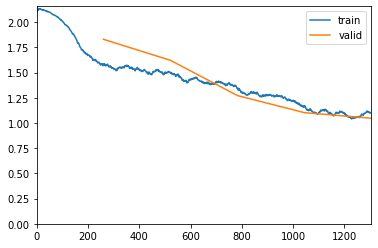

Better model found at epoch 0 with valid_loss value: 1.829450011253357.
Better model found at epoch 1 with valid_loss value: 1.6212773323059082.
Better model found at epoch 2 with valid_loss value: 1.2717138528823853.
Better model found at epoch 3 with valid_loss value: 1.1024410724639893.
Better model found at epoch 4 with valid_loss value: 1.0472149848937988.


In [28]:
train_learner(learn_b0_unb, 'EfficientNet-b0', epochs=5, lr=1e-3, balanced=False)

In [29]:
learn_b0_unb.save('stage1')

Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.948231,1.041787,0.412607,0.587393,0.649460,00:33
1,0.802776,1.064946,0.398281,0.601719,0.633751,00:35
2,0.536392,1.109689,0.411652,0.588348,0.566912,00:34
3,0.556551,1.211719,0.415473,0.584527,0.536153,00:33
4,1.032733,1.138344,0.419293,0.580707,0.632792,00:32
5,1.008861,1.065979,0.405922,0.594078,0.617486,00:33
6,0.909966,1.059603,0.408787,0.591213,0.593574,00:33
7,0.948823,1.072382,0.405922,0.594078,0.577591,00:33
8,0.912524,1.064025,0.395415,0.604585,0.569669,00:33
9,0.902373,1.063396,0.398281,0.601719,0.571272,00:33


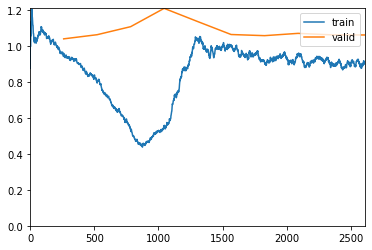

Better model found at epoch 0 with valid_loss value: 1.0417869091033936.


In [30]:
train_learner(learn_b0_unb, 'EfficientNet-b0', epochs=10, wd=1e-06, lr=1e-4, balanced=False)

## Densenet Pretrained

In [13]:
dense_learn = cnn_learner(data,models.densenet201, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ],
                         pretrained=True)

dense_learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [128, 32, 32]        8,192      False     
___________________________________________________

Saving log on:  2019_imgsz_128_DenseNet-201


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.443511,2.040746,0.547278,0.452722,0.535582,01:32
1,1.924002,1.664089,0.543458,0.456542,0.536682,01:32
2,1.627639,1.242154,0.444126,0.555874,0.607385,01:32
3,1.412598,1.164053,0.430755,0.569245,0.615319,01:31
4,1.302460,1.155329,0.418338,0.581662,0.616829,01:34


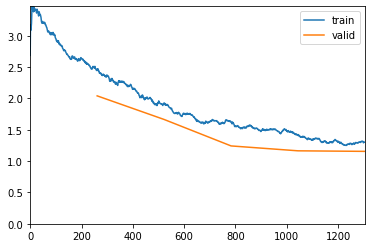

Better model found at epoch 0 with valid_loss value: 2.040745735168457.
Better model found at epoch 1 with valid_loss value: 1.6640890836715698.
Better model found at epoch 2 with valid_loss value: 1.2421543598175049.
Better model found at epoch 3 with valid_loss value: 1.1640533208847046.
Better model found at epoch 4 with valid_loss value: 1.1553287506103516.


In [19]:
train_learner(dense_learn,'DenseNet-201',epochs=5,lr=1e-3,wd=1e-6,balanced=False)

In [15]:
dense_learn.save('dense1')
dense_learn.load('dense1')
dense_learn.unfreeze()

[{'AK': 1.0727848101265822}, {'BCC': 1.0303951367781155}, {'BKL': 1.0}, {'DF': 3.549738219895288}, {'MEL': 1.0303951367781155}, {'NV': 1.036697247706422}, {'SCC': 1.2988505747126438}, {'VASC': 3.4242424242424243}]
Saving log on:  2019_imgsz_128_DenseNet-201


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.949221,1.137313,0.425979,0.574021,0.600905,01:45
1,0.575513,1.113555,0.428844,0.571156,0.638963,01:50
2,0.256064,1.153882,0.423114,0.576886,0.566544,01:45
3,0.441566,1.148843,0.432665,0.567335,0.627171,01:46
4,1.165910,1.170285,0.425024,0.574976,0.585794,01:45
5,1.157173,1.118790,0.443171,0.556829,0.582869,01:43
6,1.065318,1.112273,0.422159,0.577841,0.528808,01:44
7,1.063280,1.068908,0.416428,0.583572,0.538976,01:46
8,1.006625,1.069145,0.425024,0.574976,0.525595,01:46
9,0.964461,1.067861,0.421203,0.578797,0.532691,01:45


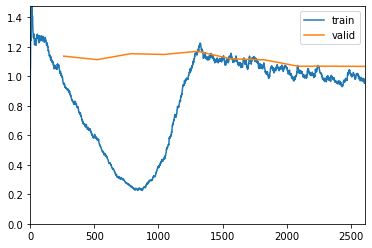

Better model found at epoch 0 with valid_loss value: 1.1373130083084106.
Better model found at epoch 1 with valid_loss value: 1.11355459690094.
Better model found at epoch 6 with valid_loss value: 1.1122734546661377.
Better model found at epoch 7 with valid_loss value: 1.0689079761505127.
Better model found at epoch 9 with valid_loss value: 1.0678611993789673.


In [21]:
train_learner(dense_learn,'DenseNet-201',epochs=10,lr=slice(1e-5,1e-4),wd=1e-6)

# Conclusion

* EfficientNet-b 0alcanza mejor accuracy al final que una densenet201 preentrenada en imagenet.

# 4) Experimento EfficientNet-b2 vs b0 en 700 imagenes aprox de 352px c/u

In [77]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b2'
model_b2_unb = EfficientNet.from_pretrained(model_name)
model_b2_unb._fc = nn.Linear(1408, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b2_unb = Learner(data,model_b2_unb, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

learn_b2_unb.summary()

Loaded pretrained weights for efficientnet-b2


EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 353, 353]        0          False     
______________________________________________________________________
BatchNorm2d          [32, 176, 176]       64         True      
______________________________________________________________________
ZeroPad2d            [32, 178, 178]       0          False     
______________________________________________________________________
BatchNorm2d          [32, 176, 176]       64         True      
______________________________________________________________________
Identity             [32, 1, 1]           0          False     
______________________________________________________________________
Identity             [8, 1, 1]            0          False     
______________________________________________________________________
Identity             [32, 176, 176]       0          False     
_________________________________________________

Saving log on:  2019_imgsz_352_EfficientNet-b2


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.389120,1.521263,0.547129,0.452871,0.506031,01:29
1,1.250517,1.451615,0.541712,0.458288,0.665376,01:29
2,1.126424,0.985157,0.356446,0.643554,0.562447,01:29
3,0.859691,0.890135,0.329361,0.670639,0.551567,01:29
4,0.748306,0.829662,0.305525,0.694475,0.548772,01:29


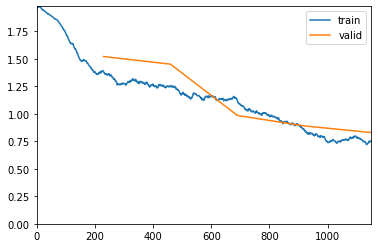

Better model found at epoch 0 with valid_loss value: 1.5212632417678833.
Better model found at epoch 1 with valid_loss value: 1.4516147375106812.
Better model found at epoch 2 with valid_loss value: 0.9851570725440979.
Better model found at epoch 3 with valid_loss value: 0.8901350498199463.
Better model found at epoch 4 with valid_loss value: 0.8296618461608887.


In [78]:
train_learner(learn_b2_unb, 'EfficientNet-b2', epochs=5, lr=1e-3, balanced=False)

In [79]:
learn_b2_unb.save('stage1_b2_unb')

Saving log on:  2019_imgsz_352_EfficientNet-b2


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.672149,0.819479,0.304442,0.695558,0.553438,01:29
1,0.535507,0.819197,0.297942,0.702058,0.548374,01:29
2,0.362463,0.892575,0.306609,0.693391,0.492719,01:29
3,0.308442,0.909055,0.301192,0.698808,0.560519,01:28
4,0.648719,0.861981,0.290358,0.709642,0.561405,01:29
5,0.608516,0.840536,0.289274,0.710726,0.488062,01:29
6,0.580710,0.804272,0.269772,0.730228,0.521411,01:29
7,0.569619,0.786831,0.280607,0.719393,0.500339,01:29
8,0.571163,0.786648,0.275190,0.724810,0.495433,01:29
9,0.517583,0.787352,0.275190,0.724810,0.505129,01:29


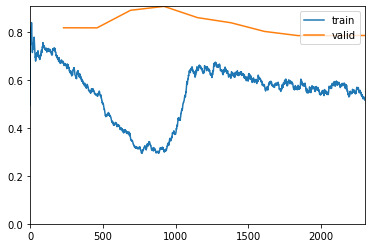

Better model found at epoch 0 with valid_loss value: 0.8194785714149475.
Better model found at epoch 1 with valid_loss value: 0.8191968202590942.
Better model found at epoch 6 with valid_loss value: 0.804272472858429.
Better model found at epoch 7 with valid_loss value: 0.7868306040763855.
Better model found at epoch 8 with valid_loss value: 0.7866480946540833.


In [80]:
train_learner(learn_b2_unb, 'EfficientNet-b2', epochs=10, wd=1e-06, lr=1e-4, balanced=False)

In [143]:
interp_unb = ClassificationInterpretation.from_learner(learn_b2_unb)

Balanced accuracy:  0.7550449645533329


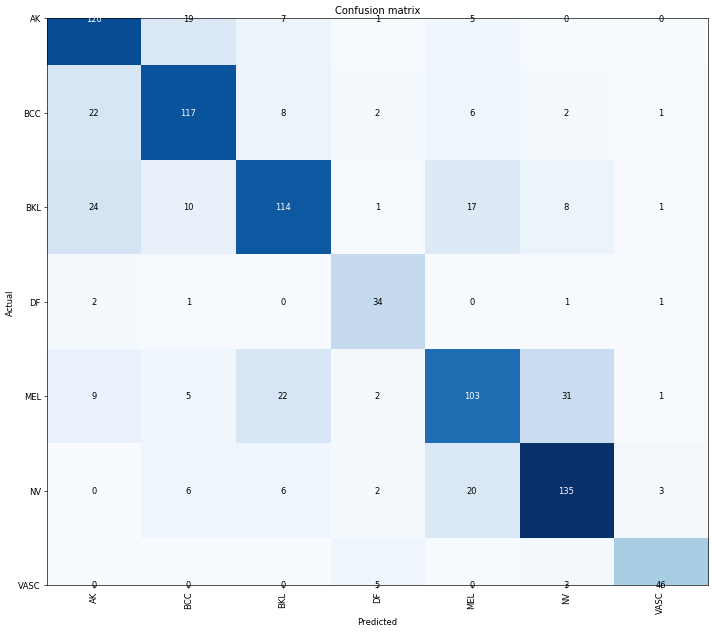

In [144]:
plot_conf_matrix(interp_unb)
plt.tight_layout()

## EfficientNet-b0

In [145]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b0'
model_b0_unb = EfficientNet.from_pretrained(model_name)
model_b0_unb._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0_unb = Learner(data,model_b0_unb, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

# learn_b0_unb.summary()

Loaded pretrained weights for efficientnet-b0


Saving log on:  2019_imgsz_352_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.371643,1.742488,0.608884,0.391116,0.470845,01:00
1,1.250212,1.211206,0.457205,0.542795,0.648085,01:01
2,1.081242,0.944097,0.347779,0.652221,0.554009,01:01
3,0.869982,0.884419,0.314193,0.685807,0.612352,01:01
4,0.766856,0.821228,0.293608,0.706392,0.609738,01:01


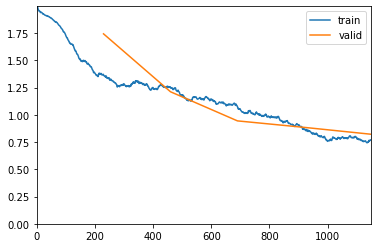

Better model found at epoch 0 with valid_loss value: 1.7424882650375366.
Better model found at epoch 1 with valid_loss value: 1.2112058401107788.
Better model found at epoch 2 with valid_loss value: 0.9440974593162537.
Better model found at epoch 3 with valid_loss value: 0.8844189047813416.
Better model found at epoch 4 with valid_loss value: 0.8212282657623291.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3552db0170>
Traceback (most recent call last):
  File "/home/mike/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/mike/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [146]:
train_learner(learn_b0_unb, 'EfficientNet-b0', epochs=5, lr=1e-3, balanced=False)

In [149]:
learn_b0_unb.save('learn_b0_unb_stage1')

Saving log on:  2019_imgsz_352_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.682157,0.820194,0.293608,0.706392,0.618143,01:01
1,0.560305,0.831034,0.288191,0.711809,0.626342,01:01
2,0.395581,0.853331,0.291441,0.708559,0.572557,01:01
3,0.366316,0.914014,0.295775,0.704225,0.562480,01:01
4,0.664157,0.830651,0.293608,0.706392,0.577405,01:01
5,0.632061,0.809431,0.279523,0.720477,0.526268,01:01
6,0.622431,0.802045,0.277356,0.722644,0.575288,01:01
7,0.603111,0.778711,0.268689,0.731311,0.541342,01:01
8,0.619321,0.776283,0.270856,0.729144,0.537544,01:01
9,0.565740,0.778176,0.270856,0.729144,0.547299,01:01


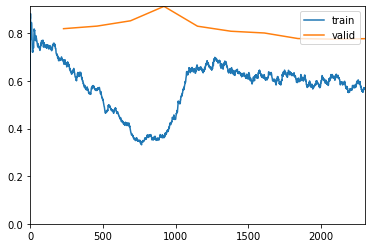

Better model found at epoch 0 with valid_loss value: 0.8201937079429626.
Better model found at epoch 5 with valid_loss value: 0.8094311952590942.
Better model found at epoch 6 with valid_loss value: 0.8020452260971069.
Better model found at epoch 7 with valid_loss value: 0.7787111401557922.
Better model found at epoch 8 with valid_loss value: 0.7762832641601562.


In [150]:
train_learner(learn_b0_unb, 'EfficientNet-b0', epochs=10, wd=1e-06, lr=1e-4, balanced=False)

In [151]:
interp_unb = ClassificationInterpretation.from_learner(learn_b0_unb)


Balanced accuracy:  0.7628818300288894


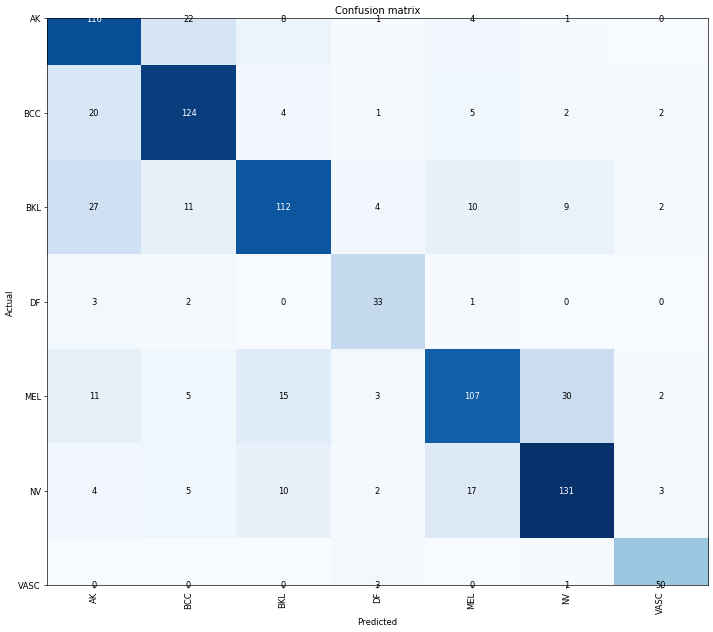

In [152]:

plot_conf_matrix(interp_unb)
plt.tight_layout()

# Conclusion

* EfficientNet-b2 supera a EfficientNet-b0 en 700 imagenes de tamaño 352 px c/u

# 5) EfficientNet-b0 en todas las imagenes 352px

In [177]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b0'
model_b0_unb = EfficientNet.from_pretrained(model_name)
model_b0_unb._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0_unb = Learner(data,model_b0_unb, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

# learn_b0_unb.summary()

Loaded pretrained weights for efficientnet-b0


[{'AK': 14.96058394160584}, {'BCC': 3.838202247191011}, {'BKL': 4.882324916626965}, {'DF': 53.09844559585492}, {'MEL': 2.7977067977067978}, {'NV': 1.0}, {'VASC': 49.990243902439026}]
Saving log on:  2019_imgsz_352_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.449680,1.619935,0.513360,0.486640,0.413517,05:21
1,1.259779,1.378782,0.521862,0.478138,0.317683,05:21
2,1.120220,1.237220,0.498583,0.501417,0.721190,05:20
3,0.915015,0.881475,0.330769,0.669231,0.689812,05:21
4,0.855178,0.806439,0.306680,0.693320,0.638419,05:20


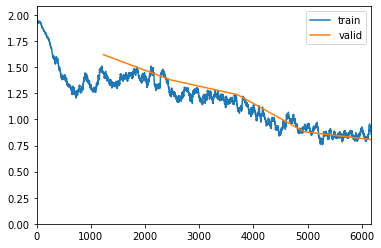

Better model found at epoch 0 with valid_loss value: 1.6199352741241455.
Better model found at epoch 1 with valid_loss value: 1.3787816762924194.
Better model found at epoch 2 with valid_loss value: 1.2372199296951294.
Better model found at epoch 3 with valid_loss value: 0.8814748525619507.
Better model found at epoch 4 with valid_loss value: 0.8064386248588562.


In [178]:
train_learner(learn_b0_unb, 'EfficientNet-b0', epochs=5, lr=1e-3, balanced=True)

In [179]:
learn_b0_unb.save('learn_b0_unb_stage1')

In [181]:
learn_b0_unb.load('learn_b0_unb_stage1')

Learner(data=ImageDataBunch;

Train: LabelList (19763 items)
x: ImageList
Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352)
y: CategoryList
MEL,NV,NV,NV,MEL
Path: picked_100000_small_352_ISIC_2019_Training_Input;

Valid: LabelList (4940 items)
x: ImageList
Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352)
y: CategoryList
NV,NV,NV,BKL,BKL
Path: picked_100000_small_352_ISIC_2019_Training_Input;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): Z

[{'AK': 14.96058394160584}, {'BCC': 3.838202247191011}, {'BKL': 4.882324916626965}, {'DF': 53.09844559585492}, {'MEL': 2.7977067977067978}, {'NV': 1.0}, {'VASC': 49.990243902439026}]
Saving log on:  2019_imgsz_352_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.917255,0.803911,0.313158,0.686842,0.665072,05:21
1,0.715551,0.794354,0.275911,0.724089,0.604830,05:20
2,0.606250,0.814558,0.284008,0.715992,0.521700,05:20
3,0.638637,0.814158,0.270243,0.729757,0.548444,05:20
4,0.784642,0.747966,0.292510,0.707490,0.724676,05:20
5,0.748091,0.749497,0.296761,0.703239,0.566950,05:19
6,0.637441,0.728860,0.270445,0.729555,0.553820,05:20
7,0.668888,0.718326,0.268623,0.731377,0.522627,05:21
8,0.701841,0.712900,0.272470,0.727530,0.524249,05:22
9,0.730545,0.713974,0.275304,0.724696,0.524157,05:22


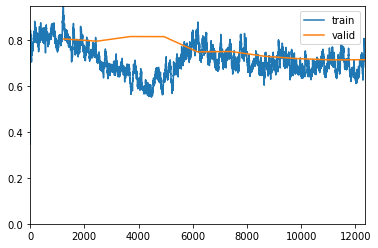

Better model found at epoch 0 with valid_loss value: 0.8039112091064453.
Better model found at epoch 1 with valid_loss value: 0.7943538427352905.
Better model found at epoch 4 with valid_loss value: 0.7479661107063293.
Better model found at epoch 6 with valid_loss value: 0.7288597226142883.
Better model found at epoch 7 with valid_loss value: 0.7183264493942261.
Better model found at epoch 8 with valid_loss value: 0.7128997445106506.


In [182]:
train_learner(learn_b0_unb, 'EfficientNet-b0', epochs=10, wd=1e-06, lr=1e-4, balanced=True)

[{'AK': 14.96058394160584}, {'BCC': 3.838202247191011}, {'BKL': 4.882324916626965}, {'DF': 53.09844559585492}, {'MEL': 2.7977067977067978}, {'NV': 1.0}, {'VASC': 49.990243902439026}]
Saving log on:  2019_imgsz_352_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.676858,0.716054,0.273887,0.726113,0.522631,05:20
1,0.558300,0.717161,0.266397,0.733603,0.509106,05:21
2,0.475479,0.731136,0.255061,0.744939,0.439210,05:19
3,0.491391,0.746610,0.257490,0.742510,0.401335,05:22
4,0.600645,0.734281,0.262146,0.737854,0.413396,05:23
5,0.585451,0.730879,0.260526,0.739474,0.434011,05:22
6,0.552486,0.726130,0.258907,0.741093,0.440610,05:22
7,0.619592,0.725811,0.261134,0.738866,0.438411,05:22
8,0.680042,0.722421,0.261538,0.738462,0.445304,05:22
9,0.737701,0.725239,0.262753,0.737247,0.448024,05:22


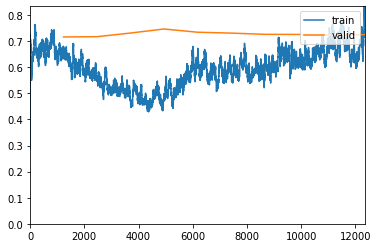

Better model found at epoch 0 with valid_loss value: 0.7160537838935852.


In [183]:
train_learner(learn_b0_unb, 'EfficientNet-b0', epochs=10, wd=1e-07, lr=1e-5, balanced=True)

In [184]:
learn_b0_unb.save('final training')

# Conclusion

Dio .743 en ISIC. Parece valer más la pena no usar todas las imagenes. Tal vez solo 700

# Test

In [258]:
#export
def test_learner(learner,name,test_images_folder): 
    learn_b2_unb.export(f'{name}.pkl')
    learn_test = load_learner(path=learner.path, file=f'{export_name}.pkl', 
                     test=ImageList.from_folder(test_images_folder),
                     )

    preds, y = learn_test.TTA(ds_type=DatasetType.Test, beta=0.4, scale=1.35)

    cols = ['image'] + learn2.data.classes


    predictions = []
    for idx, filePath in enumerate(learn2.data.test_ds.items):
        row = {}
        current_pred = preds[idx]
        row['image'] = filePath.name.replace('.jpg','')
        for idx2, cat in enumerate(learn_test.data.classes):
            row[cat] = current_pred[idx2].item()

        predictions.append(row)

    predictionsDf = pd.DataFrame(predictions, columns=cols);



    print(len(predictionsDf))
    predictionsDf = predictionsDf.rename(columns={'AK':'AKIEC'})
    # predictionsDf2 = predictionsDf.drop(columns=['SCC'])
    predictionsDf.head()
    predictions_csv_path = f'{name}.csv'
    predictionsDf.to_csv(predictions_csv_path, index=False)
    return predictions_csv_path

In [256]:
test_learner(learn_b2_unb, 'learn_b2_unb', test_folder=smallTestImagesFolderName)

1512


'learn_b2_unb.csv'